Tackle Overfitting with Data Augmentation

In [1]:
# grader-required-cell

import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt

Download the dataset from its original source by running the cell below. 

Note that the `zip` file that contains the images is unzipped under the `/tmp` directory.

In [2]:
# If the URL doesn't work, visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# And right click on the 'Download Manually' link to get a new URL to the dataset

# Note: This is a very large dataset and will take some time to download

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2023-04-04 17:50:04--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.33.17.25, 2600:1406:3c:3a4::317f, 2600:1406:3c:393::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.33.17.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.67M  67.5MB/s    in 12s     

2023-04-04 17:50:16 (64.8 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824887076/824887076]



Now the images are stored within the `/tmp/PetImages` directory. There is a subdirectory for each class, so one for dogs and one for cats.

In [3]:
# grader-required-cell

source_path = '/tmp/PetImages'

source_path_dogs = os.path.join(source_path, 'Dog')
source_path_cats = os.path.join(source_path, 'Cat')

# Deletes all non-image files (there are two .db files bundled into the dataset)
!find /tmp/PetImages/ -type f ! -name "*.jpg" -exec rm {} +

# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(source_path_dogs))} images of dogs.")
print(f"There are {len(os.listdir(source_path_cats))} images of cats.")

There are 12500 images of dogs.
There are 12500 images of cats.


You will need a directory for cats-v-dogs, and subdirectories for training
and validation. These in turn will need subdirectories for 'cats' and 'dogs'. To accomplish this, complete the `create_train_val_dirs` below:

In [5]:
# grader-required-cell

# Define root directory
root_dir = '/tmp/cats-v-dogs'

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

# GRADED FUNCTION: create_train_val_dirs
def create_train_val_dirs(root_path):
  """
  Creates directories for the train and test sets
  
  Args:
    root_path (string) - the base directory path to create subdirectories from
  
  Returns:
    None
  """

  ### START CODE HERE

  # HINT:
  # Use os.makedirs to create your directories with intermediate subdirectories
  # Don't hardcode the paths. Use os.path.join to append the new directories to the root_path parameter
  train_dir = os.path.join(root_path, 'training')
  os.makedirs(train_dir)
  cat_train_dir=os.path.join('/tmp/cats-v-dogs/training', 'cats')
  os.makedirs(cat_train_dir)
  dog_train_dir=os.path.join('/tmp/cats-v-dogs/training', 'dogs')
  os.makedirs(dog_train_dir)
  # Create the validation directory
  val_dir = os.path.join(root_path, 'validation')
  os.makedirs(val_dir)
  cat_valid_dir=os.path.join('/tmp/cats-v-dogs/validation', 'cats')
  os.makedirs(cat_valid_dir)
  dog_valid_dir=os.path.join('/tmp/cats-v-dogs/validation', 'dogs')
  os.makedirs(dog_valid_dir)

  pass
  
  
  ### END CODE HERE

  
try:
  create_train_val_dirs(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [6]:
# grader-required-cell

# Test your create_train_val_dirs function

for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/tmp/cats-v-dogs/training
/tmp/cats-v-dogs/validation
/tmp/cats-v-dogs/training/dogs
/tmp/cats-v-dogs/training/cats
/tmp/cats-v-dogs/validation/dogs
/tmp/cats-v-dogs/validation/cats


In [7]:
# grader-required-cell

# GRADED FUNCTION: split_data
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
  """
  Splits the data into train and test sets
  
  Args:
    SOURCE_DIR (string): directory path containing the images
    TRAINING_DIR (string): directory path to be used for training
    VALIDATION_DIR (string): directory path to be used for validation
    SPLIT_SIZE (float): proportion of the dataset to be used for training
    
  Returns:
    None
  """
  ### START CODE HERE
  # Step 1: Get a list of all files in the SOURCE_DIR
  files = []
  for filename in os.listdir(SOURCE_DIR):
        file = SOURCE_DIR + "/" + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")
  # Step 2: Shuffle the list of file
  random.shuffle(files)
    
    # Step 3: Split the files into a training and validation set
  split_index = int(SPLIT_SIZE * len(files))
  training_files = files[:split_index]
  validation_files = files[split_index:]    
    
    # Step 4: Copy the files into the TRANING_DIR and VALIDATION_DIR
  for filename in training_files:
      this_file = SOURCE_DIR + "/" + filename
      destination = TRAINING_DIR + "/" + filename
      copyfile(this_file, destination)

  for filename in validation_files:
      this_file = SOURCE_DIR + "/" + filename
      destination = VALIDATION_DIR + "/" + filename
      copyfile(this_file, destination)

  pass


  ### END CODE HERE

In [8]:
# grader-required-cell

# Test your split_data function

# Define paths
CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
VALIDATION_DIR = "/tmp/cats-v-dogs/validation/"

TRAINING_CATS_DIR = os.path.join(TRAINING_DIR, "cats/")
VALIDATION_CATS_DIR = os.path.join(VALIDATION_DIR, "cats/")

TRAINING_DOGS_DIR = os.path.join(TRAINING_DIR, "dogs/")
VALIDATION_DOGS_DIR = os.path.join(VALIDATION_DIR, "dogs/")

# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_CATS_DIR)) > 0:
  for file in os.scandir(TRAINING_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_DOGS_DIR)) > 0:
  for file in os.scandir(TRAINING_DOGS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_CATS_DIR)) > 0:
  for file in os.scandir(VALIDATION_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_DOGS_DIR)) > 0:
  for file in os.scandir(VALIDATION_DOGS_DIR):
    os.remove(file.path)

# Define proportion of images used for training
split_size = .9

# Run the function
# NOTE: Messages about zero length images should be printed out
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, VALIDATION_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, VALIDATION_DOGS_DIR, split_size)

# Your function should perform copies rather than moving images so original directories should contain unchanged images
print(f"\n\nOriginal cat's directory has {len(os.listdir(CAT_SOURCE_DIR))} images")
print(f"Original dog's directory has {len(os.listdir(DOG_SOURCE_DIR))} images\n")

# Training and validation splits. Check that the number of images matches the expected output.
print(f"There are {len(os.listdir(TRAINING_CATS_DIR))} images of cats for training")
print(f"There are {len(os.listdir(TRAINING_DOGS_DIR))} images of dogs for training")
print(f"There are {len(os.listdir(VALIDATION_CATS_DIR))} images of cats for validation")
print(f"There are {len(os.listdir(VALIDATION_DOGS_DIR))} images of dogs for validation")

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


Original cat's directory has 12500 images
Original dog's directory has 12500 images

There are 11249 images of cats for training
There are 11249 images of dogs for training
There are 1250 images of cats for validation
There are 1250 images of dogs for validation


In [9]:
# grader-required-cell

# GRADED FUNCTION: train_val_generators
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  """
  Creates the training and validation data generators
  
  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the testing/validation images
    
  Returns:
    train_generator, validation_generator - tuple containing the generators
  """
  ### START CODE HERE

  # Instantiate the ImageDataGenerator class (don't forget to set the arguments to augment the images)
  train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode="nearest")

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=20,
                                                      class_mode="binary",
                                                      target_size=(150, 150))

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  validation_datagen = ImageDataGenerator(rescale=1./255)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=20,
                                                                class_mode="binary",
                                                                target_size=(150, 150))
  ### END CODE HERE
  return train_generator, validation_generator

In [10]:
# grader-required-cell

# Test your generators
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [11]:
# grader-required-cell

# GRADED FUNCTION: create_model
def create_model():
  # DEFINE A KERAS MODEL TO CLASSIFY CATS V DOGS
  # USE AT LEAST 3 CONVOLUTION LAYERS

  ### START CODE HERE

  model = tf.keras.models.Sequential([ 
         # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid') 
  ])

  from tensorflow.keras.optimizers import RMSprop
  model.compile(optimizer=RMSprop(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy']) 
    
  ### END CODE HERE

  return model

Now it is time to train your model!

Note: You can ignore the `UserWarning: Possibly corrupt EXIF data.` warnings.

In [ ]:
aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa

In [12]:
# Get the untrained model
model = create_model()

# Train the model
# Note that this may take some time.
history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/15
 646/1125 [================>.............] - ETA: 5:35 - loss: 0.6757 - accuracy: 0.5838

/usr/local/lib/python3.9/dist-packages/PIL/TiffImagePlugin.py:819: UserWarning: Truncated File Read
  warnings.warn(str(msg))


1125/1125 [==============================] - 797s 707ms/step - loss: 0.6496 - accuracy: 0.6179 - val_loss: 0.6595 - val_accuracy: 0.6576
Epoch 2/15
1125/1125 [==============================] - 820s 729ms/step - loss: 0.5786 - accuracy: 0.6972 - val_loss: 0.5021 - val_accuracy: 0.7648
Epoch 3/15
1125/1125 [==============================] - 818s 727ms/step - loss: 0.5460 - accuracy: 0.7278 - val_loss: 0.4705 - val_accuracy: 0.7876
Epoch 4/15
1125/1125 [==============================] - 820s 729ms/step - loss: 0.5288 - accuracy: 0.7374 - val_loss: 0.4530 - val_accuracy: 0.7872
Epoch 5/15
1125/1125 [==============================] - 796s 708ms/step - loss: 0.5110 - accuracy: 0.7482 - val_loss: 0.4451 - val_accuracy: 0.7936
Epoch 6/15
1125/1125 [==============================] - 792s 704ms/step - loss: 0.5006 - accuracy: 0.7593 - val_loss: 0.5252 - val_accuracy: 0.7392
Epoch 7/15
1125/1125 [==============================] - 791s 703ms/step - loss: 0.4900 - accuracy: 0.7683 - val_loss: 0.451

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Once training has finished, you can run the following cell to check the training and validation accuracy achieved at the end of each epoch.

**To pass this assignment, your model should achieve a training and validation accuracy of at least 80% and the final testing accuracy should be either higher than the training one or have a 5% difference at maximum**. If your model didn't achieve these thresholds, try training again with a different model architecture, remember to use at least 3 convolutional layers or try tweaking the image augmentation process.

You might wonder why the training threshold to pass this assignment is significantly lower compared to last week's assignment. Image augmentation does help with overfitting but usually this comes at the expense of requiring more training time. To keep the training time reasonable, the same number of epochs as in the previous assignment are kept. 

However, as an optional exercise you are encouraged to try training for more epochs and to achieve really good training and validation accuracies.

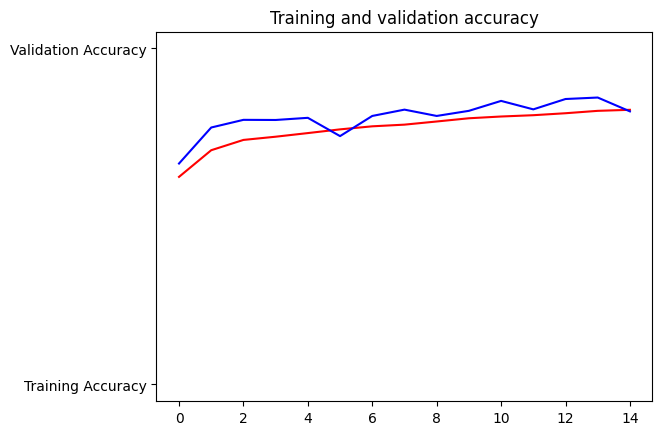

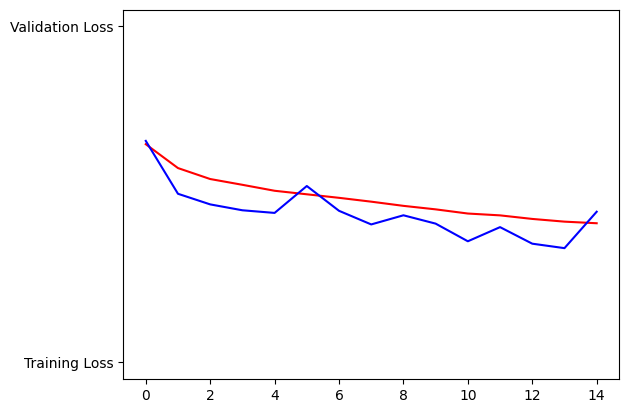

In [14]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

In [15]:
def download_history():
  import pickle
  from google.colab import files

  with open('history_augmented.pkl', 'wb') as f:
    pickle.dump(history.history, f)

  files.download('history_augmented.pkl')

download_history()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>